[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1g2AxeBNe5OgtGcsTRFps3uv4vopt_ynP?usp=sharing)

Plotting graphs to visualize the pose graph

### Libraries

In [ ]:
import json
import os
import shutil

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
from PIL import Image

### Functions

In [ ]:

def build_pose_graph(pose_graph_info, iteration, show_ids=False, show_directions=False):
    vertices = pose_graph_info["vertices"]
    edges = pose_graph_info["edges"]

    node_x = []
    node_y = []
    node_text = []
    arrow_x = []
    arrow_y = []
    arrow_u = []
    arrow_v = []
    edge_x_odom = []
    edge_y_odom = []
    edge_x_icp = []
    edge_y_icp = []

    for vertex in vertices:
        x, y = vertex["x"], vertex["y"]
        node_x.append(x)
        node_y.append(y)

        if show_ids:
            node_text.append(str(vertex["id"]))

        if show_directions:
            theta = vertex["theta"]
            arrow_length = 2
            arrow_x.append(x)
            arrow_y.append(y)
            arrow_u.append(arrow_length * np.cos(theta))
            arrow_v.append(arrow_length * np.sin(theta))

    for edge in edges:
        from_vertex = next(v for v in vertices if v["id"] == edge["from_edge"])
        to_vertex = next(v for v in vertices if v["id"] == edge["to_edge"])
        if edge["type"] == "odom":
            edge_x_odom.extend([from_vertex["x"], to_vertex["x"], None])
            edge_y_odom.extend([from_vertex["y"], to_vertex["y"], None])
        else:
            edge_x_icp.extend([from_vertex["x"], to_vertex["x"], None])
            edge_y_icp.extend([from_vertex["y"], to_vertex["y"], None])

    edge_trace_odom = go.Scatter(
        x=edge_x_odom, y=edge_y_odom,
        line=dict(width=1, color='red'),
        hoverinfo='none',
        mode='lines',
        name='Odom Edges')

    edge_trace_icp = go.Scatter(
        x=edge_x_icp, y=edge_y_icp,
        line=dict(width=1, color='green'),
        hoverinfo='none',
        mode='lines',
        name='ICP Edges')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text' if show_ids else 'markers',
        marker=dict(size=8, color='black'),
        text=node_text if show_ids else None,
        textposition='top center',
        hoverinfo='text',
        name='Vertices')

    fig = go.Figure(data=[edge_trace_odom, edge_trace_icp, node_trace])
    fig.update_layout(title=f"Pose Graph Iteration {iteration}",
                      showlegend=True,
                      hovermode='closest',
                      margin=dict(b=0, l=0, r=0, t=40),
                      width=1000, height=1000)
    return fig

In [ ]:
def display_pose_graph(json_path, iteration=0, show_ids=False, show_directions=False):
    iterationa_str = str(iteration)
    if iteration < 10:
        iterationa_str = "0" + iterationa_str
    with open(json_path, "r") as file:
        data = json.load(file)
        fig = build_pose_graph(data[iterationa_str], iterationa_str, show_ids, show_directions)
        display(fig)

In [ ]:
def save_pose_graph(json_path, path_to_dir, show_ids=False, show_directions=False):
    with open(json_path, "r") as file:
        data = json.load(file)
        for iteration_number in data:
            fig = build_pose_graph(data[iteration_number], iteration_number, show_ids, show_directions)
            output_file = os.path.join(path_to_dir, f"pose_graph_iteration_{iteration_number}.png")
            fig.write_image(output_file)

In [ ]:
def parse_json_and_extract_icp_errors(json_path, iteration):
    with open(json_path, "r") as file:
        data = json.load(file)

    icp_errors = []
    iteration_data = data[str(iteration)]
    edges = iteration_data.get("edges", [])
    for edge in edges:
        if edge.get("type") == "icp":
            icp_errors.append((edge["error_val"], edge["from_edge"], edge["to_edge"]))

    return icp_errors

In [ ]:
def build_icp_errors_histogram(icp_errors, iteration):
    sorted_icp_errors = sorted(
        icp_errors, key=lambda x: (min(x[1], x[2]), max(x[1], x[2]))
    )
    errors = [error[0] for error in sorted_icp_errors]
    edge_indices = list(range(1, len(errors) + 1))
    df = pd.DataFrame({"Edge Index": edge_indices, "Error": errors})

    fig = px.bar(
        df,
        x="Edge Index",
        y="Error",
        title=f"ICP Errors Histogram iteration={iteration}",
        labels={"Edge Index": "Edge Number", "Error": "ICP Error"},
        text="Error",
        color="Error",
        color_continuous_scale=px.colors.diverging.RdYlGn,
    )
    fig.update_traces(texttemplate="%{text:.2f}", textposition="outside")
    fig.update_layout(height=1000, width=1000)
    fig.update_yaxes(type="log", title_text="ICP Error (log scale)")
    return fig

In [ ]:
def save_icp_errors_histogram(json_path, output_dir):
    with open(json_path, "r") as file:
        data = json.load(file)

    for iteration in data.keys():
        icp_errors = parse_json_and_extract_icp_errors(json_path, iteration)
        if icp_errors:
            fig = build_icp_errors_histogram(icp_errors, iteration)
            output_file = os.path.join(
                output_dir, f"icp_errors_histogram_iteration_{iteration}.png"
            )
            fig.write_image(output_file)

In [ ]:
def display_icp_errors_histogram(json_path, iteration=0):
    iteration_str = str(iteration)
    if iteration < 10:
        iteration_str = "0" + iteration_str
    with open(json_path, "r") as file:
        data = json.load(file)

    icp_errors = parse_json_and_extract_icp_errors(json_path, iteration_str)
    if icp_errors:
        fig = build_icp_errors_histogram(icp_errors, iteration_str)
        display(fig)

In [ ]:
def create_combined_images(icp_output_dir, pose_graph_output_dir, res_output_dir):
    combined_output_dir = os.path.join(res_output_dir, "combine")
    os.makedirs(combined_output_dir, exist_ok=True)

    iterations = [f"iteration_{i:02}" for i in range(len(os.listdir(icp_output_dir)))]
    for iteration in iterations:
        icp_image_path = os.path.join(
            icp_output_dir, f"icp_errors_histogram_{iteration}.png"
        )
        pose_graph_image_path = os.path.join(
            pose_graph_output_dir, f"pose_graph_{iteration}.png"
        )
        if os.path.exists(icp_image_path) and os.path.exists(pose_graph_image_path):
            icp_image = Image.open(icp_image_path)
            pose_graph_image = Image.open(pose_graph_image_path)

            combined_image = Image.new(
                "RGB",
                (
                    icp_image.width + pose_graph_image.width,
                    max(icp_image.height, pose_graph_image.height),
                ),
            )
            combined_image.paste(icp_image, (0, 0))
            combined_image.paste(pose_graph_image, (icp_image.width, 0))
            combined_image_path = os.path.join(
                combined_output_dir, f"combined_{iteration}.png"
            )
            combined_image.save(combined_image_path)

In [ ]:
def create_gif_from_combined_images(combined_output_dir, gif_output_path):
    images = []
    for filename in sorted(os.listdir(combined_output_dir)):
        if filename.endswith(".png"):
            image_path = os.path.join(combined_output_dir, filename)
            images.append(imageio.imread(image_path))

    imageio.mimsave(gif_output_path, images, duration=6)

### Running

In [ ]:
res_output_dir = "res_fin"
json_path = "small_counter3.json"

In [ ]:
# icp_output_dir = f"{res_output_dir}/icp_errors"
# pose_graph_output_dir = f"{res_output_dir}/pose_graph_res"
# os.makedirs(res_output_dir, exist_ok=True)
# os.makedirs(icp_output_dir, exist_ok=True)
# os.makedirs(pose_graph_output_dir, exist_ok=True)
# save_pose_graph(json_path, pose_graph_output_dir)
# save_icp_errors_histogram(json_path, icp_output_dir)
# create_combined_images(icp_output_dir, pose_graph_output_dir, res_output_dir)
# combined_output_dir = os.path.join(res_output_dir, "combine")
# gif_output_path = os.path.join(res_output_dir, "combined_animation.gif")
# create_gif_from_combined_images(combined_output_dir, gif_output_path)

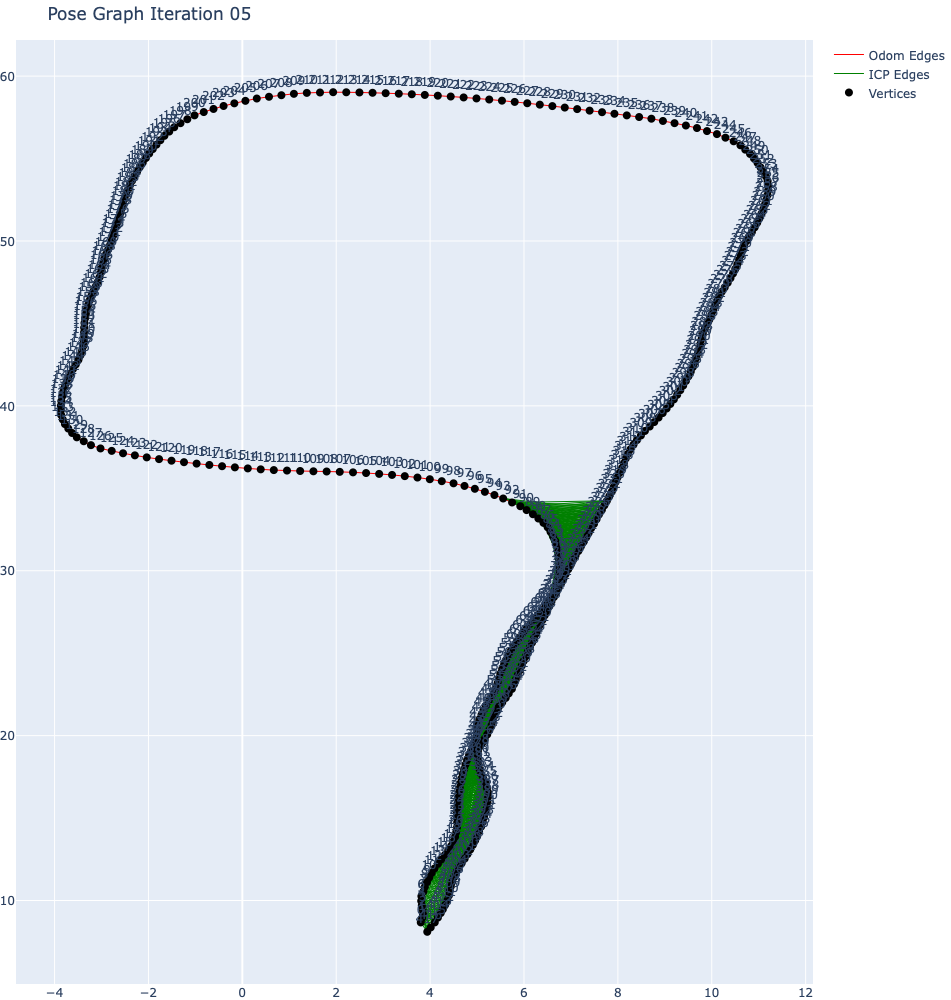

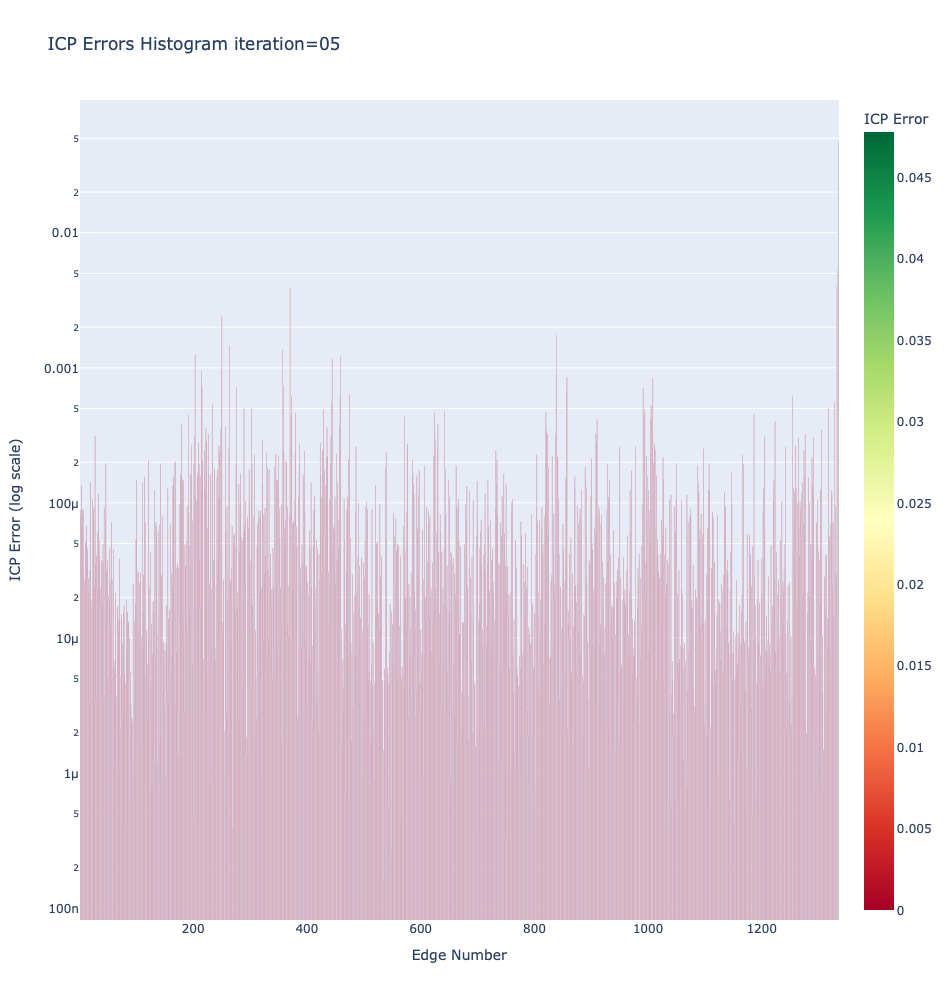

In [ ]:
display_pose_graph(json_path, 5, True, True)
display_icp_errors_histogram(json_path, 5)

### JSON structure:



```
{
    "{iteration}": {
        "edges": [
            {
                "error_val": 0.0,
                "from_edge": 0,
                "to_edge": 1,
                "type": "odom"/"icp"
            },
            ...
        ],
        "vertices": [
            {
                "id": 0,
                "theta": 4.615004767022551,
                "x": 3.8010182076379677,
                "y": 8.670056334750697
            },
            ...
        ]
    },
    "{iteration}": {
      ...
    },
    ...
}
```

